In [47]:
#!/usr/bin/env python3

#-------------------------------------------------------------------------#
#  James Semate - B35825/S25M25/014   ***MSCS***  written using python3             #
#-------------------------------------------------------------------------#

#Question one

In [1]:


####json data
""" json simulated data"""

vehicles_input= [
  {
    "plate_number": "UAX 123A",
    "owner": "Amina",
    "engine_cc": 2000,
    "base_tax": 150000,
    "vehicle_type": "Car",
    "extra": 5
  },
  {
    "plate_number": "UBT 876B",
    "owner": "Benson",
    "engine_cc": 5000,
    "base_tax": 300000,
    "vehicle_type": "Truck",
    "extra": 12000
  },
  {
    "plate_number": "UCF 555C",
    "owner": "Claire",
    "engine_cc": 130,
    "base_tax": 18000,
    "vehicle_type": "Motorbike",
    "extra": "private"
  },
    {
    "plate_number": "UEQ 565C",
    "owner": "Carol",
    "engine_cc": 150,
    "base_tax": 20000,
    "vehicle_type": "Motorbike",
    "extra": "boda"
  },
  {
    "plate_number": "UDG 999D",
    "owner": "David",
    "engine_cc": 1800,
    "base_tax": 140000,
    "vehicle_type": "Car",
    "extra": 4
  }
]
#extra in passegers has data for passenger capacity
#extra in truck has data for load capacity
#extra in motorbike has data  for bike type


from abc import ABC, abstractmethod
from datetime import datetime
from pathlib import Path
import json
import os
import argparse
import requests
from requests.exceptions import RequestException
import time
from datetime import datetime

def timeStamp():
    #import time
     ts = time.time()
     return datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
 

# Q1: Vehicle classes and logic

class Vehicle:
    def __init__(self, plate_number, owner, engine_cc, base_tax):
        self.plate_number = plate_number
        self.owner = owner
        self.engine_cc = float(engine_cc)
        self.base_tax = float(base_tax)

    def calculate_tax(self):
        raise NotImplementedError("Subclasses must implement calculate_tax()")

    """ creates a dictorary """
    def to_dict(self): 
        return {
            "vehicle_type": self.__class__.__name__,
            "plate_number": self.plate_number,
            "owner": self.owner,
            "engine_cc": self.engine_cc,
            "base_tax": self.base_tax
        }

class Car(Vehicle):
    def __init__(self, plate_number, owner, engine_cc, base_tax, passenger_capacity):
        super().__init__(plate_number, owner, engine_cc, base_tax)
        self.passenger_capacity = int(passenger_capacity) #adds passenger capacity

    def calculate_tax(self):
        return round(self.base_tax + (self.engine_cc * 0.05), 2)

    def to_dict(self):
        d = super().to_dict() #creates dictionary from super class : vehicle
        #adds passenger capacity and calculated tax plus updates the dictionary
        d.update({"passenger_capacity": self.passenger_capacity, "calculated_tax": self.calculate_tax()})
        return d

class Truck(Vehicle):
    def __init__(self, plate_number, owner, engine_cc, base_tax, load_capacity):
        super().__init__(plate_number, owner, engine_cc, base_tax)
        self.load_capacity = float(load_capacity) #adds load capacity

    def calculate_tax(self):
        return round(self.base_tax + (self.load_capacity * 0.1), 2)

    def to_dict(self):
        d = super().to_dict()  #creates dictionary from super class : vehicle
        #adds load capacity and calculated tax
        d.update({"load_capacity": self.load_capacity, "calculated_tax": self.calculate_tax()})
        return d

class Motorbike(Vehicle):
    def __init__(self, plate_number, owner, engine_cc, base_tax, bike_type):
        super().__init__(plate_number, owner, engine_cc, base_tax)
        self.bike_type = bike_type

    def calculate_tax(self):
        return round(self.base_tax + 20000.0, 2)

    def to_dict(self):
        d = super().to_dict() #creates dictionary from super class : vehicle
        #adds load capacity and calculated tax
        d.update({"bike_type": self.bike_type, "calculated_tax": self.calculate_tax()})
        return d

def load_json(jsonString):
    #with path.open("r", encoding="utf-8") as f:
        return jsonString #json.load(jsonString)

def save_json(path: Path, data):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

def runVehicleModels(jsonStringInput, vehicle_registry_output: Path):
    """
    Q1: Read vehicles_input.json, instantiate appropriate Vehicle subclasses,
    demonstrate polymorphism by calling calculate_tax(), and save vehicle_registry.json
    """
    try:
        vehicles_input = load_json(jsonStringInput)  #API calling , API json output simulated response
    except FileNotFoundError:
        print(f"Input Null: {jsonStringInput}")
        return
    except json.JSONDecodeError as e:
        print(f"Error parsing {jsonStringInput}: {e}")
        return

    vehicle_objects = []
    for rec in vehicles_input:
        # Expect fields: plate_number, owner, engine_cc, base_tax, vehicle_type, extra
        try:
            plate = rec["plate_number"]
            owner = rec["owner"]
            engine_cc = rec["engine_cc"]
            base_tax = rec["base_tax"]
            vtype = rec["vehicle_type"]
            extra = rec.get("extra")   #used to store extra data
        except KeyError as e:
            print(f"Skipping vehicle due to missing field: {e}")
            continue

        try:
            if vtype == "Car":
                obj = Car(plate, owner, engine_cc, base_tax, extra)
            elif vtype == "Truck":
                obj = Truck(plate, owner, engine_cc, base_tax, extra)
            elif vtype == "Motorbike":
                obj = Motorbike(plate, owner, engine_cc, base_tax, extra)
            else:
                print(f"Unknown vehicle_type '{vtype}' for plate {plate} - skipping")
                continue
            vehicle_objects.append(obj) #saves subclass  objects into alist
        except Exception as e:
            print(f"Error creating {vtype} for plate {plate}: {e}")
            continue

    # Polymorphism 
    print("\nVehicle tax calculations using polymorphism:")
    for v in vehicle_objects: #iterates throuh each object and calculates its tax
        print(f" - {v.__class__.__name__} {v.plate_number} (owner: {v.owner}) -> Tax: UGX {v.calculate_tax():,.2f}")

    # Save registry
    # datetime.utcnow().isoformat() + "Z",
    registry = { "generated_at":  timeStamp() , "vehicles": [v.to_dict() for v in vehicle_objects] }
    save_json(vehicle_registry_output, registry)
    print(f"\nSaved vehicle json data to => {vehicle_registry_output}")
#    print(f"\n\njson_data:  {registry}")


# print(current_directory = os.getcwd())
# get_current_dir = os.path.dirname(os.path.realpath(__file__)) # Path.cwd()
# #save_path = full_file_path = current_dir + "/vehicle_registry_output"
# fileSave_path = os.path.join( current_dir, "vehicle_registry_output.json")
# runVehicleModels(vehicles_input, fileSave_path)

current_dir = os.getcwd() #+ "/vehicle_registry_output.json"
fileSave_path = os.path.join(current_dir, "vehicle_registry.json")
#print(f"Current working directory: {current_directory}")
runVehicleModels(vehicles_input, fileSave_path)





Vehicle tax calculations using polymorphism:
 - Car UAX 123A (owner: Amina) -> Tax: UGX 150,100.00
 - Truck UBT 876B (owner: Benson) -> Tax: UGX 301,200.00
 - Motorbike UCF 555C (owner: Claire) -> Tax: UGX 38,000.00
 - Motorbike UEQ 565C (owner: Carol) -> Tax: UGX 40,000.00
 - Car UDG 999D (owner: David) -> Tax: UGX 140,090.00

Saved vehicle json data to => /home/jovyan/work/vehicle_registry.json


In [ ]:
#Question two

In [9]:

from abc import ABC, abstractmethod
from datetime import datetime
from pathlib import Path
import json
import os
import argparse
import requests
from requests.exceptions import RequestException
import time
from datetime import datetime

#simulated json sacco data
members_input = [
  {
    "name": "Evelyn Tina",
    "id_no": "12345678",
    "savings_balance": 500000,
    "member_type": "Trader"
  },
  {
    "name": "Fred Okena",
    "id_no": "87654321",
    "savings_balance": 750000,
    "member_type": "Farmer"
  },
  {
    "name": "Grace Pato",
    "id_no": "11223344",
    "savings_balance": 250000,
    "member_type": "Trader"
  }
]



class Member(ABC):
    def __init__(self, name, id_no, savings_balance):
        self.name = name
        self.id_no = id_no
        self.savings_balance = float(savings_balance)

    @abstractmethod
    def loan_eligibility(self):
        pass

    def to_dict(self):   
        return {
            "member_type": self.__class__.__name__,
            "name": self.name,
            "id_no": self.id_no,
            "savings_balance": self.savings_balance,
            "loan_eligibility_ugx": self.loan_eligibility()
        }
    @staticmethod
    def get_exchange_rate_usd_per_ugx(timeout=3):
        """
        Tries to fetch USD per 1 UGX. On failure returns fallback and reason.
        Returns: (rate, source_description)
        """
        fallback_rate = 0.00027  # fallback value (1 UGX = 0.00027 USD)
        try:
            resp = requests.get(EXCHANGE_API_URL, timeout=timeout)  #tries to connect but will fail
            resp.raise_for_status()
            data = resp.json()
            rate = data.get("rates", {}).get("USD")
            if rate is None:
                raise KeyError("USD rate missing in API response")
            return float(rate), f"live:{EXCHANGE_API_URL}"
        except (RequestException, ValueError, KeyError) as e:
          
            return fallback_rate, f"fallback (error: {e})"
        
   

class TraderMember(Member):
    #4 × savings balance ,calculation
    def loan_eligibility(self):
        return round(4.0 * self.savings_balance, 2)

class FarmerMember(Member):
    #6 × savings balance ,calculation
    def loan_eligibility(self):
        return round(6.0 * self.savings_balance, 2)


# Hardcoded API URL for the exchange rate
EXCHANGE_API_URL = "https://api.com/get_rate"  #dummy url
def load_json(jsonString):
    #with path.open("r", encoding="utf-8") as f:
        return jsonString #json.load(jsonString)

def save_json(path: Path, data):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=2, ensure_ascii=False)



def Sacco(members_input, sacco_report_output: Path):
    """
    Read members_input.json, create Member subclass instances, compute loan eligibility and display it,
    convert to USD using exchange rate fetched via requests (with exception handling).
    """
    try:
        members_input = load_json(members_input)
   
    except json.JSONDecodeError as e:
        print(f"Error parsing {members_input}: {e}")
        return

    member_objects = []
    for rec in members_input:
        try:
            name = rec["name"]
            id_no = rec["id_no"]
            savings = rec["savings_balance"]
            mtype = rec["member_type"]
        except KeyError as e:
            print(f" Skipping member due to missing field: {e}")
            continue

        if mtype == "Trader": #memberType
            mem = TraderMember(name, id_no, savings)
        elif mtype == "Farmer":
            mem = FarmerMember(name, id_no, savings)
        else:
            print(f"Unknown member_type '{mtype}' for {name} - skipping")
            continue
        member_objects.append(mem)

    rate, source = Member.get_exchange_rate_usd_per_ugx() # calling static method
    print(f"\nExchange rate used (USD per 1 UGX): {rate}  (source: {source})")

    report = {
        "generated_at": datetime.utcnow().isoformat() + "Z",
        "exchange_rate_usd_per_ugx": rate,
        "exchange_rate_source": source,
        "members": []
    }

    print("\nSACCO loan eligibility (UGX and USD):")
    for mem in member_objects:
        eligible_ugx = mem.loan_eligibility()
        eligible_usd = round(eligible_ugx * rate, 2) #converting to usd using the xrate
        print(f" - {mem.name} ({mem.__class__.__name__}): \
        Savings UGX {mem.savings_balance:,.2f} -> Loan Eligible UGX {eligible_ugx:,.2f} -> USD {eligible_usd:,.2f}")
        report["members"].append({
            "name": mem.name,
            "id_no": mem.id_no,
            "member_type": mem.__class__.__name__,
            "savings_balance_ugx": mem.savings_balance,
            "loan_eligibility_ugx": eligible_ugx,
            "loan_eligibility_usd": eligible_usd
        })
 
    save_json(sacco_report_output, report)    #not needed
    print(f"Saved SACCO members report to => {sacco_report_output}")
current_dir = os.getcwd() #+ "/vehicle_registry_output.json"
fileSave_path = os.path.join(current_dir, "sacco_report.json")
Sacco(members_input, fileSave_path)




Exchange rate used (USD per 1 UGX): 0.00027  (source: fallback (error: HTTPSConnectionPool(host='api.com', port=443): Max retries exceeded with url: /get_rate (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x74abfd34be10>: Failed to resolve 'api.com' ([Errno -5] No address associated with hostname)"))))

SACCO loan eligibility (UGX and USD):
 - Evelyn Tina (TraderMember):         Savings UGX 500,000.00 -> Loan Eligible UGX 2,000,000.00 -> USD 540.00
 - Fred Okena (FarmerMember):         Savings UGX 750,000.00 -> Loan Eligible UGX 4,500,000.00 -> USD 1,215.00
 - Grace Pato (TraderMember):         Savings UGX 250,000.00 -> Loan Eligible UGX 1,000,000.00 -> USD 270.00
Saved SACCO members report to => /home/jovyan/work/sacco_report.json


In [ ]:
#Question 3

In [4]:
import random
from datetime import datetime, timedelta
from typing import List, Optional, Dict

# Simulated Sensor "API" JSON-like samples
# Each entry represents a possible response from a traffic sensor
# measuring how many cars are waiting at a given road.
# Some entries simulate errors (None or malformed data) for error handling tests.
SENSOR_SAMPLES = [
    {"road": "Jinja Road",   "car_count": 2},
    {"road": "Jinja Road",   "car_count": 10},
    {"road": "Market Street","car_count": 5},
    {"road": "Main Avenue",  "car_count": 20},
    None,                    # Simulate timeout (no response)
    {"bad": "format"},       # Simulate malformed data
]

# Simulated sensor function
def simple_sensor(road: str, i: int) -> int:
    """
    Simulates calling a sensor API to get the car count.
    Returns an integer number of cars or raises an error if the data is bad.
    """
    item = SENSOR_SAMPLES[i % len(SENSOR_SAMPLES)]  # pick one sample by index
    if item is None:
        raise ConnectionError("timeout")  # simulate a timeout
    if not isinstance(item, dict) or "car_count" not in item:
        raise ValueError("malformed")     # simulate corrupted data

    # Add small random variation to mimic noisy readings
    return max(0, int(item["car_count"]) + random.choice([-1, 0, 1]))


# Base TrafficLight class 
class TrafficLight:
    """
    Represents a normal (non-smart) traffic light.
    Demonstrates encapsulation using a private attribute __current_state.
    """
    def __init__(self, road: str, green: int = 30, red: int = 30):
        self.road = road
        self.default_green = green
        self.default_red = red
        self.__current_state = "RED"  # private attribute (cannot be accessed directly outside the class)

    def status(self) -> str:
        """Return the current state (GREEN or RED)."""
        return self.__current_state

    def turn_green(self, duration: Optional[int] = None) -> int:
        """Turn light GREEN for a given duration."""
        d = self.default_green if duration is None else max(1, int(duration))
        self.__current_state = "GREEN"
        return d

    def turn_red(self, duration: Optional[int] = None) -> int:
        """Turn light RED for a given duration."""
        d = self.default_red if duration is None else max(1, int(duration))
        self.__current_state = "RED"
        return d


# SmartTrafficLight class (inherits from TrafficLight)

class SmartTrafficLight(TrafficLight):
    """
    Smart version that adjusts light durations based on simulated car sensor data.
    Uses simple logic to extend green time if many cars are detected.
    """
    def __init__(self, road: str, base_green: int = 30, base_red: int = 30):
        super().__init__(road, base_green, base_red)
        self.base_green = base_green
        self.base_red = base_red
        self._call_idx = 0  # counter to get different sensor samples each call

    def _get_cars(self) -> int:
        """Get number of cars from the simulated sensor with error handling."""
        try:
            c = simple_sensor(self.road, self._call_idx)
            self._call_idx += 1
            return c
        except (ConnectionError, ValueError) as e:
            # Handle known errors gracefully and assume 0 cars
            print(f"[Warn] sensor {self.road}: {e}. Using 0 cars.")
            self._call_idx += 1
            return 0

    def decide(self) -> Dict[str, int]:
        """
        Decide the duration of green/red lights based on car density.
        Rule:
          - For every 5 cars, add +5 seconds to green.
          - Keep red constant for simplicity.
        """
        cars = self._get_cars()
        extra = (cars // 5) * 5
        green = max(10, min(120, self.base_green + extra))
        red = self.base_red  # keep red fixed
        return {"green": green, "red": red, "cars": cars}


# Simple simulation runner
def simulate(lights: List[TrafficLight], cycles: int = 3):
    """
    Simulate multiple traffic light cycles and print short logs.
    Example output:
        [09:15] Jinja Road: Green for 60s, Red for 30s, cars=10.
    """
    now = datetime.now().replace(second=0, microsecond=0)
    t = now

    for _ in range(cycles):
        for L in lights:
            # Run smart or normal behavior depending on the type
            if isinstance(L, SmartTrafficLight):
                d = L.decide()
                g = L.turn_green(d["green"])
                r = L.turn_red(d["red"])
                cars = d["cars"]
            else:
                g = L.turn_green()
                r = L.turn_red()
                cars = None

            # Print short traffic log
            time_str = t.strftime("%H:%M")
            car_part = f", cars={cars}" if cars is not None else ""
            print(f"[{time_str}] {L.road}: Green for {g}s, Red for {r}s{car_part}.")
            
            # Simulate time passing (advance clock)
            t += timedelta(seconds=(g + r))

        # Add random delay between cycles
        t += timedelta(seconds=random.randint(3, 10))


lights = [
        SmartTrafficLight("Jinja Road", 30, 30),
        SmartTrafficLight("Market Street", 25, 25),
        TrafficLight("Main Avenue", 40, 40),
    ]

    # Run 3 simulation cycles
simulate(lights, cycles=3)


[14:21] Jinja Road: Green for 30s, Red for 30s, cars=3.
[14:22] Market Street: Green for 25s, Red for 25s, cars=1.
[14:22] Main Avenue: Green for 40s, Red for 40s.
[14:24] Jinja Road: Green for 35s, Red for 30s, cars=9.
[14:25] Market Street: Green for 35s, Red for 25s, cars=10.
[14:26] Main Avenue: Green for 40s, Red for 40s.
[14:27] Jinja Road: Green for 35s, Red for 30s, cars=5.
[14:28] Market Street: Green for 25s, Red for 25s, cars=4.
[14:29] Main Avenue: Green for 40s, Red for 40s.


In [ ]:
#Question 4

In [5]:
import json

class Student:
    def __init__(self, student_id, name, marks):
        self.student_id = str(student_id)
        self.name = str(name)
        # expect marks as dict {subject: score}
        if not isinstance(marks, dict):
            raise ValueError("marks must be a dictionary")
        # store validated floats
        self.marks = {s: float(v) for s, v in marks.items() if 0 <= float(v) <= 100}

    def total(self):
        return sum(self.marks.values())

    def average(self):
        return self.total() / len(self.marks) if self.marks else 0.0

    def grade(self):
        a = self.average()
        if a >= 80: return "A"
        if a >= 70: return "B"
        if a >= 60: return "C"
        if a >= 50: return "D"
        return "F"

    def evaluate(self):
        return f"{self.student_id} | {self.name} | Total: {self.total():.1f} | Avg: {self.average():.1f} | Grade: {self.grade()}"

    def to_dict(self):
        return {"type": "Student", "student_id": self.student_id, "name": self.name, "marks": self.marks}

    @classmethod
    def from_dict(cls, d):
        return cls(d["student_id"], d["name"], d.get("marks", {}))


class PostgraduateStudent(Student):
    def __init__(self, student_id, name, marks, research_topic, thesis_score):
        super().__init__(student_id, name, marks)
        self.research_topic = str(research_topic)
        self.thesis_score = float(thesis_score)

    def evaluate_thesis(self):
        # simple rule: Pass if thesis_score >= 65 and coursework avg >= 60
        if self.thesis_score >= 65 and self.average() >= 60:
            return "Pass"
        return "Revise"

    def evaluate(self):
        base = super().evaluate()
        return f"{base} | Research: {self.research_topic} | Thesis: {self.evaluate_thesis()}"

    def to_dict(self):
        d = super().to_dict()
        d.update({"type": "PostgraduateStudent", "research_topic": self.research_topic, "thesis_score": self.thesis_score})
        return d

    @classmethod
    def from_dict(cls, d):
        return cls(d["student_id"], d["name"], d.get("marks", {}), d.get("research_topic", ""), d.get("thesis_score", 0))


# Persistence helpers 
def save_students(students, path="students.json"):
    with open(path, "w", encoding="utf-8") as f:
        json.dump([s.to_dict() for s in students], f, indent=2)

def load_students(path="students.json"):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    out = []
    for item in data:
        if item.get("type") == "PostgraduateStudent":
            out.append(PostgraduateStudent.from_dict(item))
        else:
            out.append(Student.from_dict(item))
    return out

# Simulated API JSON
SIMULATED_API = """
{
  "students": [
    {"type":"Student","student_id":"S1","name":"Alice","marks":{"Math":78,"Eng":82,"CS":90}},
    {"type":"Student","student_id":"S2","name":"Bob","marks":{"Math":62,"Eng":58,"CS":70}},
    {"type":"PostgraduateStudent","student_id":"P1","name":"Carol","marks":{"AI":85,"RM":80},"research_topic":"Improving link aggregation","thesis_score":78}
  ]
}
"""

def parse_api(json_str):
    payload = json.loads(json_str)
    students = []
    for rec in payload.get("students", []):
        if rec.get("type") == "PostgraduateStudent":
            students.append(PostgraduateStudent.from_dict(rec))
        else:
            students.append(Student.from_dict(rec))
    return students

if __name__ == "__main__":
    try:
        students = parse_api(SIMULATED_API)
        print("Evaluations:")
        for s in students:
            print(s.evaluate())

        save_students(students)                # write to students.json
        loaded = load_students()               # read back
        print("\nLoaded (coursework summaries):")
        for s in loaded:
            print(s.evaluate())

        try:
            Student("bad", "Broken", {"Math": 150})  # invalid mark (filtered out)
        except Exception as e:
            print("\nHandled invalid input:", e)

    except Exception as e:
        print("Error:", e)


Evaluations:
S1 | Alice | Total: 250.0 | Avg: 83.3 | Grade: A
S2 | Bob | Total: 190.0 | Avg: 63.3 | Grade: C
P1 | Carol | Total: 165.0 | Avg: 82.5 | Grade: A | Research: Improving link aggregation | Thesis: Pass

Loaded (coursework summaries):
S1 | Alice | Total: 250.0 | Avg: 83.3 | Grade: A
S2 | Bob | Total: 190.0 | Avg: 63.3 | Grade: C
P1 | Carol | Total: 165.0 | Avg: 82.5 | Grade: A | Research: Improving link aggregation | Thesis: Pass


In [ ]:
#Question 5


--- All fetched tracks ---
   artist        track_name  play_count  popularity country_produced
    Azawi         Quinamino     1520000          82           Uganda
    Azawi        Obaewulira      860000          71           Uganda
  Sheebah            Nkyano      920000          75           Uganda
  Sheebah          Tomorrow      400000          60           Uganda
Bebe Cool           African      540000          68           Uganda
Bebe Cool Love You Everyday      200000          55           Uganda
 Spurfowl       City Lights      120000          44            Kenya
Saved uganda_tracks.json
Saved plot to popularity_plot.png


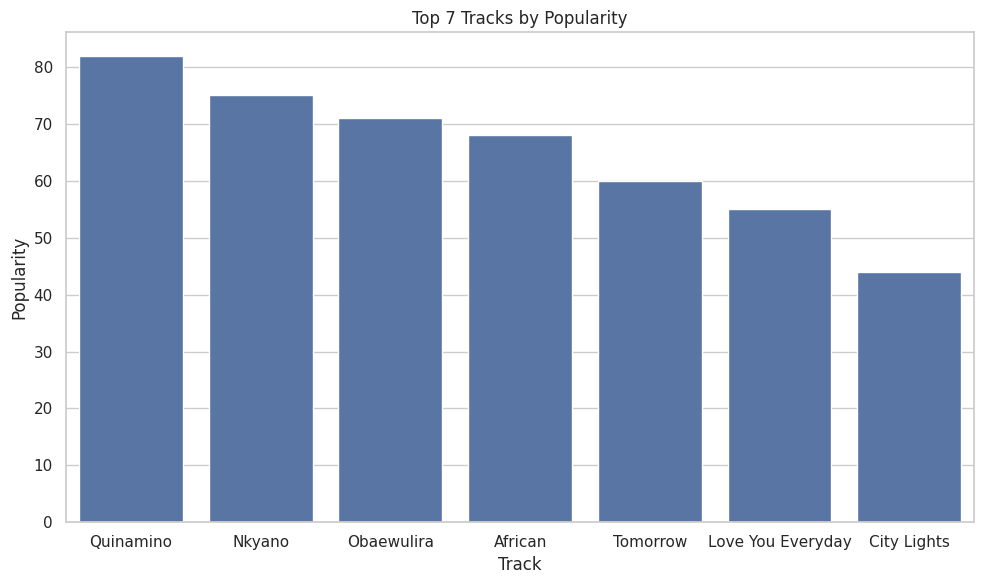


--- Local (produced in Uganda) tracks ---
   artist        track_name  play_count  popularity country_produced
    Azawi         Quinamino     1520000          82           Uganda
    Azawi        Obaewulira      860000          71           Uganda
  Sheebah            Nkyano      920000          75           Uganda
  Sheebah          Tomorrow      400000          60           Uganda
Bebe Cool           African      540000          68           Uganda
Bebe Cool Love You Everyday      200000          55           Uganda
Saved uganda_local_tracks.json


In [6]:
"""
uganda_music_analytics.py
Simple demo program for UgandaMusicAnalytics and LocalArtistAnalytics.

Requirements (to run locally):
  pip install pandas seaborn matplotlib
(seaborn is optional; the script falls back to matplotlib if seaborn is not present)
"""

import json
from typing import List, Dict, Any, Optional
import pandas as pd

# Try seaborn; fall back to matplotlib only if seaborn not available

try:
    import seaborn as sns
    import matplotlib.pyplot as plt
    _USE_SEABORN = True
except Exception:
    import matplotlib.pyplot as plt
    _USE_SEABORN = False

#Mock JSON from API
MOCK_JSON = {
    "artists": [
        {
            "name": "Azawi",
            "tracks": [
                {"name": "Quinamino", "play_count": 1520000, "popularity": 82, "country_produced": "Uganda"},
                {"name": "Obaewulira", "play_count": 860000, "popularity": 71, "country_produced": "Uganda"}
            ]
        },
        {
            "name": "Sheebah",
            "tracks": [
                {"name": "Nkyano", "play_count": 920000, "popularity": 75, "country_produced": "Uganda"},
                {"name": "Tomorrow", "play_count": 400000, "popularity": 60, "country_produced": "Uganda"}
            ]
        },
        {
            "name": "Bebe Cool",
            "tracks": [
                {"name": "African", "play_count": 540000, "popularity": 68, "country_produced": "Uganda"},
                {"name": "Love You Everyday", "play_count": 200000, "popularity": 55, "country_produced": "Uganda"}
            ]
        },
        {
            "name": "Spurfowl",
            "tracks": [
                {"name": "City Lights", "play_count": 120000, "popularity": 44, "country_produced": "Kenya"}
            ]
        },
        {
            "name": "Diamond",
            "tracks": [
                {"name": "Jeje", "play_count": 2200000, "popularity": 90, "country_produced": "Tanzania"},
                {"name": "Waah!", "play_count": 1800000, "popularity": 86, "country_produced": "Tanzania"},
                {"name": "Marry You", "play_count": 950000, "popularity": 78, "country_produced": "Tanzania"}
            ]
        }
    ]
}
#Custom Exceptions
class InvalidTokenError(Exception):
    pass

class APILimitError(Exception):
    pass


class UgandaMusicAnalytics:
    """Base analytics class. In a real setting this would use spotipy; here we use mock data."""
    def __init__(self, token: Optional[str] = None, use_mock: bool = True):
        self.token = token
        self.use_mock = use_mock
        # simulate token states:
        # "VALID" -> OK, "RATE" -> rate-limited, anything else or None -> invalid
        self._token_state = "VALID" if token == "VALID" else ("RATE" if token == "RATE" else "INVALID")

    def _check_token(self):
        if self._token_state == "INVALID":
            raise InvalidTokenError("API token invalid or missing.")
        if self._token_state == "RATE":
            raise APILimitError("API rate limit exceeded. Try again later.")

    def fetch_top_tracks(self, artist_name: str) -> List[Dict[str, Any]]:
        """
        Fetch top tracks for artist_name.
        Uses MOCK_JSON when use_mock is True.
        """
        if not self.use_mock:
            # Real API calls would go here (e.g., using spotipy). Not implemented in this simple demo.
            raise NotImplementedError("Real Spotify API calls are not implemented in this demo.")
        # simulate token validation
        self._check_token()
        for art in MOCK_JSON["artists"]:
            if art["name"].lower() == artist_name.lower():
                return [dict(t) for t in art["tracks"]]
        return []  # artist not found

    def get_tracks_df(self, artist_names: List[str]) -> pd.DataFrame:
        """Return DataFrame with columns: artist, track_name, play_count, popularity, country_produced"""
        rows = []
        for name in artist_names:
            try:
                tracks = self.fetch_top_tracks(name)
            except (InvalidTokenError, APILimitError):
                raise
            except Exception as e:
                print(f"Warning: unexpected error fetching {name}: {e}")
                tracks = []
            for t in tracks:
                rows.append({
                    "artist": name,
                    "track_name": t.get("name"),
                    "play_count": t.get("play_count", 0),
                    "popularity": t.get("popularity", 0),
                    "country_produced": t.get("country_produced", "Unknown")
                })
        df = pd.DataFrame(rows, columns=["artist", "track_name", "play_count", "popularity", "country_produced"])
        return df

    def save_to_json(self, df: pd.DataFrame, filepath: str) -> None:
        records = df.to_dict(orient="records")
        with open(filepath, "w", encoding="utf-8") as f:
            json.dump(records, f, ensure_ascii=False, indent=2)

    def plot_popularity(self, df: pd.DataFrame, top_n: int = 10, savepath: Optional[str] = None) -> None:
        """Plot track popularity using seaborn (preferred) or matplotlib (fallback)."""
        if df.empty:
            print("No data to plot.")
            return
        df_sorted = df.sort_values("popularity", ascending=False).head(top_n)
        if _USE_SEABORN:
            sns.set(style="whitegrid")
            plt.figure(figsize=(10, 6))
            ax = sns.barplot(x="track_name", y="popularity", data=df_sorted)
         #   ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            ax.set_xlabel("Track")
            ax.set_ylabel("Popularity")
            ax.set_title(f"Top {len(df_sorted)} Tracks by Popularity")
            plt.tight_layout()
        else: 
            pass
        """ plt.figure(figsize=(10, 6))
            plt.bar(df_sorted["track_name"], df_sorted["popularity"])
            plt.xticks(rotation=45, ha="right")
            plt.xlabel("Track")
            plt.ylabel("Popularity")
            plt.title(f"Top {len(df_sorted)} Tracks by Popularity")
            plt.tight_layout()"""
        if savepath:
            plt.savefig(savepath)
            print(f"Saved plot to {savepath}")
        plt.show()

class LocalArtistAnalytics(UgandaMusicAnalytics):
    """Subclass that filters tracks produced in Uganda only."""
    def __init__(self, token: Optional[str] = None, use_mock: bool = True):
        super().__init__(token=token, use_mock=use_mock)

    def get_local_tracks_df(self, artist_names: List[str]) -> pd.DataFrame:
        df = self.get_tracks_df(artist_names)
        if df.empty:
            return df
        return df[df["country_produced"].str.lower() == "uganda"]


def main():
    # To simulate:
    # - token="VALID" -> success
    # - token="INVALID" or None -> InvalidTokenError
    # - token="RATE" -> APILimitError
    token = "VALID"  # change to "RATE" or None to see error handling
    artists = ["Azawi", "Sheebah", "Bebe Cool", "Spurfowl"]

    analytics = UgandaMusicAnalytics(token=token, use_mock=True)
    try:
        df = analytics.get_tracks_df(artists)
    except InvalidTokenError as e:
        print("ERROR:", e)
        return
    except APILimitError as e:
        print("ERROR:", e)
        return

    print("\n--- All fetched tracks ---")
    print(df.to_string(index=False))

    # Save all tracks to JSON
    analytics.save_to_json(df, "uganda_tracks.json")
    print("Saved uganda_tracks.json")

    # Plot popularity (Seaborn preferred)
    analytics.plot_popularity(df, top_n=8, savepath="popularity_plot.png")

    # Filter local (produced in Uganda)
    local = LocalArtistAnalytics(token=token, use_mock=True)
    local_df = local.get_local_tracks_df(artists)
    print("\n--- Local (produced in Uganda) tracks ---")
    print(local_df.to_string(index=False))
    local.save_to_json(local_df, "uganda_local_tracks.json")
    print("Saved uganda_local_tracks.json")

if __name__ == "__main__":
    main()


In [ ]:
#Question 6

Loaded data from local file: exchange_rates.json
Cleaned data: 9 rows, columns: ['USD', 'GBP', 'EUR']
Calculated monthly averages: 3 months.


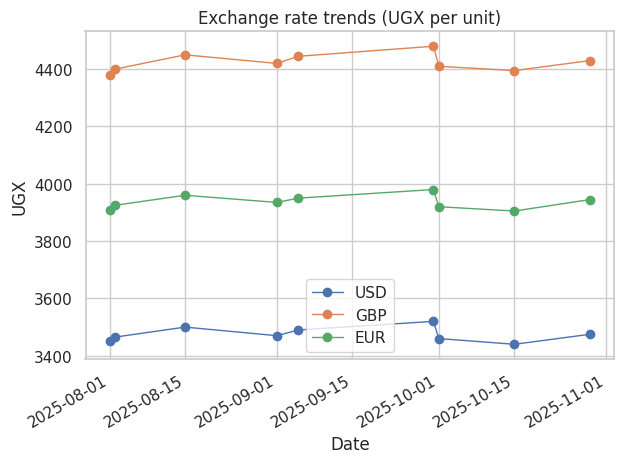

Exported processed monthly averages to CSV: processed_rates.csv
Exported processed monthly averages to JSON: processed_rates.json
Pipeline completed successfully.

Monthly averages:
             USD      GBP      EUR
Month                             
2025-08  3471.67  4410.00  3931.67
2025-09  3493.33  4448.33  3955.00
2025-10  3458.33  4411.67  3923.33


<Figure size 640x480 with 0 Axes>

In [7]:
#found a query only for exchange rates here
#https://www.bou.or.ug/bouwebsite/bouwebsitecontent/ExchangeRates/scripts.MajorExchangeRates/index.jsp?year=2025&month=Oct&day=28


import json
import os
from datetime import datetime
from io import StringIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests  # used to demonstrate HTTP attempt; exceptions are handled


# local exchange_rates.json --- simulated API

SAMPLE_JSON = {
    "source": "BankOfUganda-simulated",
    "base_currency": "UGX",
    "rates": [
        # daily entries: date in ISO format and rates as dictionary
        {"date": "2025-08-01", "USD": 3450.0, "GBP": 4380.0, "EUR": 3910.0},
        {"date": "2025-08-02", "USD": 3465.0, "GBP": 4400.0, "EUR": 3925.0},
        {"date": "2025-08-15", "USD": 3500.0, "GBP": 4450.0, "EUR": 3960.0},
        {"date": "2025-09-01", "USD": 3470.0, "GBP": 4420.0, "EUR": 3935.0},
        {"date": "2025-09-05", "USD": 3490.0, "GBP": 4445.0, "EUR": 3950.0},
        {"date": "2025-09-30", "USD": 3520.0, "GBP": 4480.0, "EUR": 3980.0},
        {"date": "2025-10-01", "USD": 3460.0, "GBP": 4410.0, "EUR": 3920.0},
        {"date": "2025-10-15", "USD": 3440.0, "GBP": 4395.0, "EUR": 3905.0},
        {"date": "2025-10-29", "USD": 3475.0, "GBP": 4430.0, "EUR": 3945.0}
    ]
}

LOCAL_FILENAME = "exchange_rates.json"

# Write sample file if not exists (so the script is runnable)
if not os.path.exists(LOCAL_FILENAME):
    with open(LOCAL_FILENAME, "w", encoding="utf-8") as f:
        json.dump(SAMPLE_JSON, f, indent=2)
    print(f"Created sample local '{LOCAL_FILENAME}' with {len(SAMPLE_JSON['rates'])} entries.")

class ExchangeRatePipeline:
    def __init__(self, local_path: str = LOCAL_FILENAME, remote_url: str = None):
        """
        :param local_path: path to local JSON file with exchange rates
        :param remote_url: optional remote JSON URL (if available)
        """
        self.local_path = local_path
        self.remote_url = remote_url
        self.raw_data = None
        self.df = None  # pandas DataFrame after cleaning
        self.processed = None  # aggregated results

    def fetch(self, timeout: int = 5):
        """
        Attempt to fetch remote JSON first (if remote_url provided),
        otherwise load local JSON. Handles HTTP errors and file errors.
        """
        # Try remote fetch if provided
        if self.remote_url:
            try:
                resp = requests.get(self.remote_url, timeout=timeout)
                resp.raise_for_status()
                self.raw_data = resp.json()
                print("Loaded data from remote URL.")
                return
            except requests.exceptions.RequestException as e:
                # Log and fall back to local file
                print(f"Remote fetch failed: {e}. Falling back to local file.")

        # Load from local
        try:
            with open(self.local_path, "r", encoding="utf-8") as f:
                self.raw_data = json.load(f)
            print(f"Loaded data from local file: {self.local_path}")
        except FileNotFoundError:
            raise FileNotFoundError(f"Local exchange rates file not found: {self.local_path}")
        except json.JSONDecodeError as e:
            raise ValueError(f"Invalid JSON in local file: {e}")

    def clean_transform(self):
        """
        Convert self.raw_data into a clean pandas DataFrame with:
        - datetime index as 'date'
        - numeric columns USD, GBP, EUR
        - sorted by date
        """
        if self.raw_data is None:
            raise RuntimeError("No raw_data loaded. Call fetch() first.")

        # Expecting raw_data['rates'] to be a list of dicts
        records = self.raw_data.get("rates", None)
        if records is None:
            raise KeyError("Expected key 'rates' in JSON data")

        # Build DataFrame
        df = pd.DataFrame.from_records(records)

        # Validate date column
        if "date" not in df.columns:
            raise KeyError("Each record must include 'date' field")

        # Parse dates
        df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors="coerce")
        if df["date"].isnull().any():
            raise ValueError("Some 'date' values could not be parsed into datetime")

        # Ensure currencies exist; if missing columns, set NaN
        for code in ["USD", "GBP", "EUR"]:
            if code not in df.columns:
                df[code] = np.nan

        # Convert currency columns to numeric
        df[["USD", "GBP", "EUR"]] = df[["USD", "GBP", "EUR"]].apply(pd.to_numeric, errors="coerce")

        # Sort and set index
        df = df.sort_values("date").reset_index(drop=True)
        df.set_index("date", inplace=True)

        # Drop rows that have all currencies missing
        df = df.dropna(axis=0, how="all", subset=["USD", "GBP", "EUR"])

        self.df = df
        print(f"Cleaned data: {len(self.df)} rows, columns: {list(self.df.columns)}")

    # def calculate_monthly_averages(self):
    #     """
    #     Calculate monthly averages per currency using numpy where appropriate.
    #     Returns a DataFrame with 'year-month' index and average rates.
    #     """
    #     if self.df is None:
    #         raise RuntimeError("DataFrame not ready. Call clean_transform() first.")

    #     # Resample by month and compute mean (use pandas mean which uses numpy under the hood)
    #     """
    #     monthly = self.df.resample("ME").mean() #df.resample('ME').mean() 
    #     performs a time-based grouping (in this case, by month-end) and
    #     then calculates a separate mean for each group. 
        
    #     """
    #     monthly = self.df.resample("ME").mean() 

    #     # Add a 'year_month' column for friendly index
    #     monthly.index = monthly.index.to_period("M")
    #     self.processed = monthly
    #     print(f"Calculated monthly averages: {len(self.processed)} months.")
    #     return self.processed

    def calculate_monthly_averages(self):
        """Calculate monthly averages explicitly using NumPy."""
        if self.df is None:
            raise RuntimeError("Call clean_transform() first.")

        # Extract month labels
        months = self.df.index.to_period("M").astype(str)
        self.df["Month"] = months

        results = []
        for month, group in self.df.groupby("Month"):
            # Use numpy.mean explicitly
            avg_usd = np.mean(group["USD"].to_numpy())
            avg_gbp = np.mean(group["GBP"].to_numpy())
            avg_eur = np.mean(group["EUR"].to_numpy())
            results.append({"Month": month, "USD": avg_usd, "GBP": avg_gbp, "EUR": avg_eur})

        monthly_df = pd.DataFrame(results).set_index("Month")
        self.monthly_avg = monthly_df
        # print("Monthly averages computed using NumPy.")
        # return monthly_df
        self.processed = monthly_df
        print(f"Calculated monthly averages: {len(self.processed)} months.")
        return self.processed
        
    def plot_trends(self, save_to: str = None):
        """
        Plot the time series for USD, GBP, EUR using matplotlib.
        If save_to is provided, saves the figure to that path.
        """
        if self.df is None:
            raise RuntimeError("DataFrame not ready. Call clean_transform() first.")

        ax = self.df[["USD", "GBP", "EUR"]].plot(marker='o', linewidth=1)
        ax.set_title("Exchange rate trends (UGX per unit)")
        ax.set_xlabel("Date")
        ax.set_ylabel("UGX")
        ax.grid(True)
        plt.tight_layout()
        plt.show()

        # if save_to:
        #     plt.savefig(save_to)
        #     print(f"Saved plot to {save_to}")
        # else:
        #     print("Displaying plot inline (if environment supports it).")
        #     plt.show()

        # Clear plot so repeated calls don't overplot
        plt.clf()

    def export_processed(self, csv_path: str = "processed_rates.csv", json_path: str = "processed_rates.json"):
        """
        Export the monthly averages (self.processed) to CSV and JSON.
        """
        if self.processed is None:
            raise RuntimeError("No processed data. Call calculate_monthly_averages() first.")

        # CSV
        self.processed.to_csv(csv_path, index=True)
        print(f"Exported processed monthly averages to CSV: {csv_path}")

        # For JSON, convert PeriodIndex to string for JSON serialization
        processed_copy = self.processed.copy()
        processed_copy.index = processed_copy.index.astype(str)
        processed_copy.to_json(json_path, orient="index", indent=2)
        print(f"Exported processed monthly averages to JSON: {json_path}")

    # Convenience run method demonstrating the pipeline with safe error handling
    def run_all(self):
        try:
            self.fetch()
            self.clean_transform()
            self.calculate_monthly_averages()
            # plot to file rather than requiring interactive display
            self.plot_trends(save_to="exchange_trends.png")
            self.export_processed(csv_path="processed_rates.csv", json_path="processed_rates.json")
            print("Pipeline completed successfully.")
        except Exception as e:
            # Top-level catch to avoid crashing; in real code, log exception details
            print(f"Pipeline failed with error: {e}")


# remote = "https://example.com/exchange_rates.json"
# pipeline = ExchangeRatePipeline(local_path=LOCAL_FILENAME, remote_url=remote)

pipeline = ExchangeRatePipeline(local_path=LOCAL_FILENAME, remote_url=None)
pipeline.run_all()

# Print the processed monthly averages to stdout
if pipeline.processed is not None:
    print("\nMonthly averages:")
    print(pipeline.processed.round(2))

